<a href="https://colab.research.google.com/github/kurtsenol/machine-learning/blob/master/TopicModeling/LDA_50_topics_final4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import numpy as np
import pandas as pd

## Dataset

Below is our dataset:

In [3]:
df = pd.read_csv("./NewsArticles_Top10Keywords.csv")
df.drop_duplicates(subset=['link'], inplace=True)
df['text']= df['title']+ '. '+ df['content']

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10567 entries, 0 to 10640
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   news_id  10567 non-null  int64 
 1   title    10567 non-null  object
 2   content  10567 non-null  object
 3   link     10567 non-null  object
 4   date     10567 non-null  object
 5   text     10567 non-null  object
dtypes: int64(1), object(5)
memory usage: 577.9+ KB


In [5]:
df['date']= pd.to_datetime(df['date'])

In [6]:
df.head()

,news_id,title,content,link,date,text
0,1,Do chatbots really help you stay productive?,GUEST: When Slack burst onto the workplace sce...,http://venturebeat.com/?p=2141494,2017-01-01,Do chatbots really help you stay productive?. ...
1,2,Spanish social advertising company Adsmurai ra...,Barcelona-based social advertising company Ads...,http://venturebeat.com/?p=2141069,2017-01-01,Spanish social advertising company Adsmurai ra...
2,3,HTC: No Vive 2 at CES,I\u2019d wager most people who bought the HTC ...,http://venturebeat.com/?p=2141559,2017-01-01,HTC: No Vive 2 at CES. I\u2019d wager most peo...
3,4,Chinese firms reportedly ordered to pay Disney...,(Reuters) &#8212;\xa0A Shanghai court ordered ...,http://venturebeat.com/?p=2141698,2017-01-01,Chinese firms reportedly ordered to pay Disney...
4,5,AWS sees growth in database migrations,Public cloud market leader Amazon Web Services...,http://venturebeat.com/?p=2141375,2017-01-01,AWS sees growth in database migrations. Public...


In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

In [23]:
df['year'] = pd.DatetimeIndex(df['date']).year
df['month'] = pd.DatetimeIndex(df['date']).month

In [24]:
df['year'].value_counts()

year
2017    10567
Name: count, dtype: int64

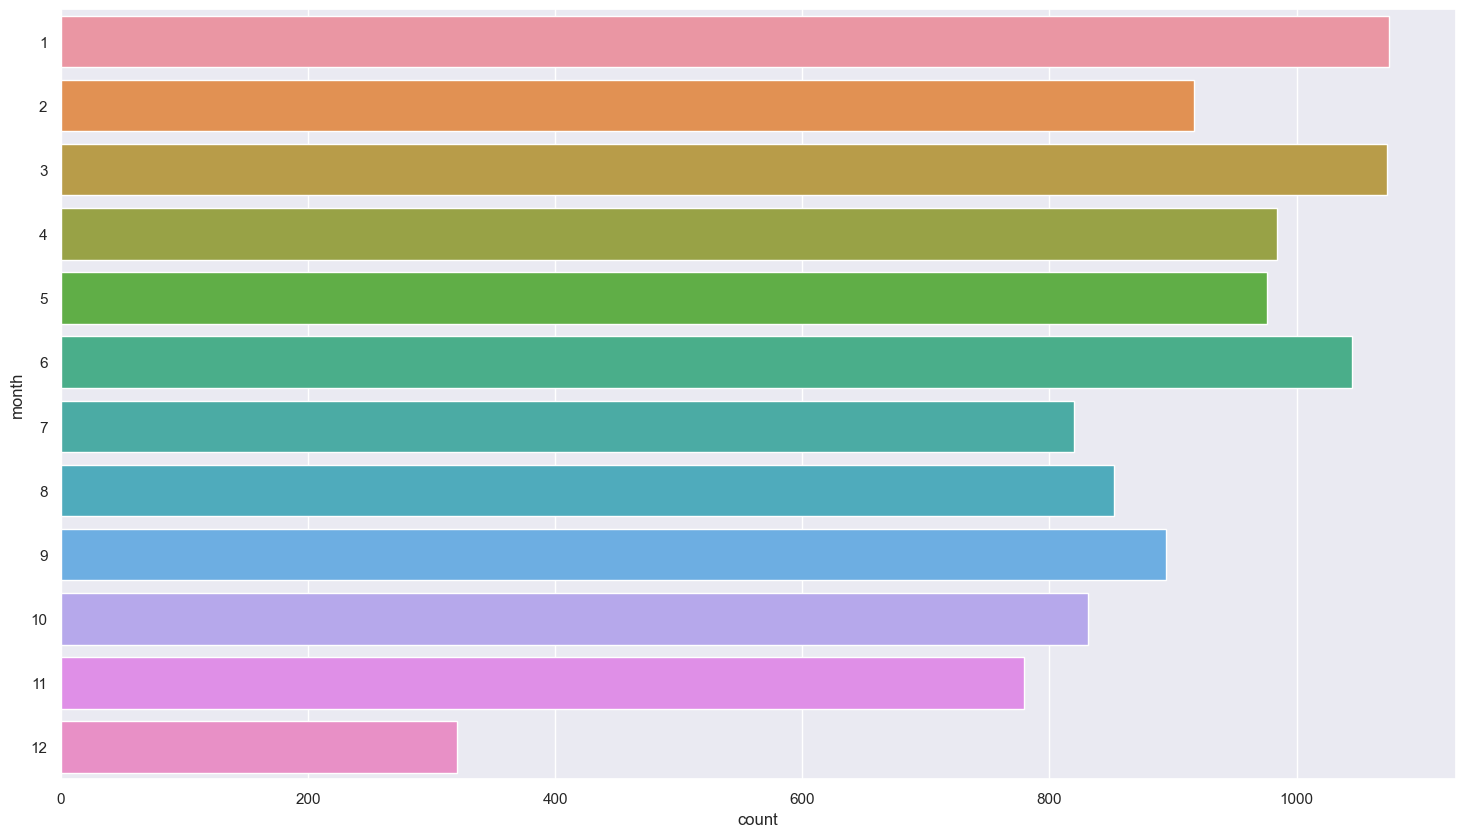

In [25]:
plt.figure(figsize=(18,10))
sns.countplot(y='month', data=df, orient='h');

## Analysis

In [36]:
papers = list(df.text.values)

In [37]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\v.veerati\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [38]:
stop_words = nltk.corpus.stopwords.words('english')

In [39]:
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt

### Tokenize Sentences and Clean

In [40]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = papers
data_words = list(sent_to_words(data))

In [41]:
data_words[:5]

[['do',
  'chatbots',
  'really',
  'help',
  'you',
  'stay',
  'productive',
  'guest',
  'when',
  'slack',
  'burst',
  'onto',
  'the',
  'workplace',
  'scene',
  'employees',
  'rejoiced',
  'finally',
  'there',
  'was',
  'way',
  'to',
  'chat',
  'with',
  'one',
  'another',
  'without',
  'having',
  'to',
  'send',
  'dreaded',
  'email',
  'or',
  'worse',
  'get',
  'up',
  'and',
  'actually',
  'go',
  'chat',
  'with',
  'your',
  'coworker',
  'face',
  'to',
  'face',
  'thanks',
  'to',
  'slack',
  'and',
  'handful',
  'of',
  'other',
  'messaging',
  'platforms',
  'businesses',
  'could',
  'easily',
  'communicate',
  'across',
  'teams',
  'using'],
 ['spanish',
  'social',
  'advertising',
  'company',
  'adsmurai',
  'raises',
  'million',
  'barcelona',
  'based',
  'social',
  'advertising',
  'company',
  'adsmurai',
  'has',
  'received',
  'ac',
  'million',
  'million',
  'in',
  'second',
  'round',
  'of',
  'funding',
  'led',
  'by',
  'venture'

### Build the Bigram, Trigram Models and Lemmatize

In [42]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=10, threshold=20) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=20)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])


# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc), deacc=True, min_len=3) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags and len(token.text)>3])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc), deacc=True, min_len=3) if word not in stop_words] for doc in texts_out]    
    return texts_out

In [43]:
data_ready = process_words(data_words)  # processed Text Data!

Above we preprocess the corpus that includes: 
- removing stop words,
- doing lemmatization,
- implementing ngrams,
- selection of tokens based on speech of tags (*keep the words that are either noun, adjective, verb or adverb*)

### Create the Dictionary and Corpus needed for Topic Modeling

In [44]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

print('Total Vocabulary Size:', len(id2word))

Total Vocabulary Size: 16966


After preprocessing step we form a dictionary that the model requires.

In [45]:
# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

In [48]:
dict_corpus = {}

for i in range(len(corpus)):
    for idx, freq in corpus[i]:
        if id2word[idx] in dict_corpus:
            dict_corpus[id2word[idx]] += freq
        else:
            dict_corpus[id2word[idx]] = freq

In [19]:
dict_df = pd.DataFrame.from_dict(dict_corpus, orient='index', columns=['freq'])

In [49]:
dict_corpus

{'actually': 100,
 'bad': 45,
 'burst': 13,
 'business': 837,
 'chat': 125,
 'chatbot': 283,
 'communicate': 38,
 'coworker': 6,
 'dread': 6,
 'easily': 48,
 'email': 183,
 'employee': 216,
 'face': 229,
 'finally': 188,
 'guest': 1037,
 'handful': 43,
 'help': 965,
 'message': 229,
 'platform': 954,
 'productive': 10,
 'really': 157,
 'rejoice': 3,
 'scene': 59,
 'send': 145,
 'slack': 102,
 'stay': 66,
 'team': 573,
 'thank': 146,
 'use': 903,
 'workplace': 58,
 'adsmurai': 1,
 'advertising': 115,
 'axon': 2,
 'base': 807,
 'bstartup': 1,
 'company': 3319,
 'enisa': 1,
 'financing': 54,
 'fund': 443,
 'funding_le': 81,
 'government': 150,
 'group': 337,
 'launch': 2069,
 'partner': 344,
 'program': 273,
 'receive': 199,
 'sabadell': 1,
 'second_round': 10,
 'social': 227,
 'spanish': 18,
 'specialize': 36,
 'bring': 648,
 'button': 46,
 'buy': 111,
 'controller': 76,
 'cord': 6,
 'design': 465,
 'early': 418,
 'ergonomic': 3,
 'grip': 2,
 'hard': 145,
 'htc_vive': 33,
 'improvement':

In [50]:
dict_df['freq'].describe()

count    16250.000000
mean        18.552000
std         94.188856
min          1.000000
25%          1.000000
50%          2.000000
75%          8.000000
max       5230.000000
Name: freq, dtype: float64

C:\Users\v.veerati\AppData\Local\Temp\ipykernel_22316\3561769931.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dict_df['freq'], bins=100);


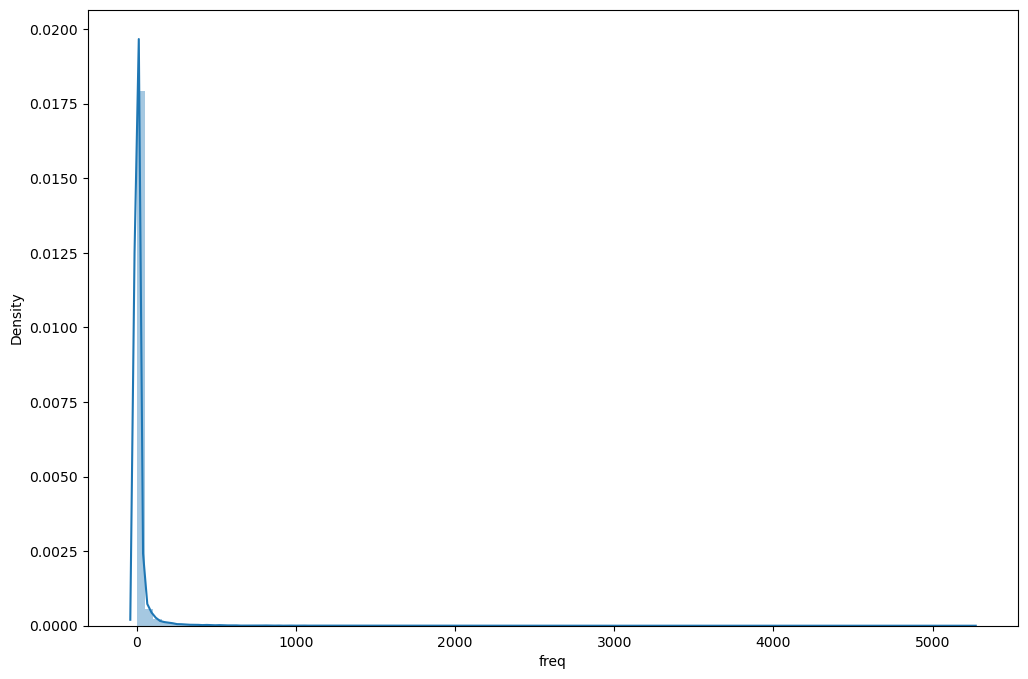

In [51]:
import seaborn as sns
plt.figure(figsize=(12,8))
sns.distplot(dict_df['freq'], bins=100);

Above is the graph for word frequencies of our dictionary, just to have general idea about the words and their frequencies. Most of the words have frequency values less than 200. 

Below you can find the list of high frequency words in descending order. We will add those words that appear 3000 times or  more to stop list and restart the preprocess step to get better topic clusters. As expected, sector specific and general writing words have high frequencies.  

In [53]:
dict_df[dict_df.freq>2500].sort_values('freq', ascending=False).head(60)

,freq
game,5230
company,3531
today,2946
announce,2525


In [25]:
# extension = dict_df[dict_df.freq>3000].index.tolist()

In [26]:
# stop_words.extend(extension)

In [54]:
data_ready = process_words(data_words)

In [55]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

print('Total Vocabulary Size:', len(id2word))

Total Vocabulary Size: 16966


In [56]:
 print("After removing the high frequency words there remains **{}** words in our dictionary.".format(len(id2word)))

After removing the high frequency words there remains **16966** words in our dictionary.


In [57]:
# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

In [58]:
corpus

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 2),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 2),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 2),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 1)],
 [(30, 1),
  (31, 2),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 2),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 2),
  (49, 2),
  (50, 1)],
 [(12, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 1),
  (59, 1),
  (60, 1),
  (61, 2),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 1),
  (66, 1),
  (67, 1),
  (68, 1),
  (69, 1),
  (70, 1),
  (71, 1),
  (72, 1),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 2)],
 [(77, 3),
  (78, 2),
  (79, 1),
  (80, 2),
  (81, 2),
  (82, 1),
  (83, 1),
  (84, 1),
  (85, 2),
  (86, 1),
  (87, 1),
  (88, 1),
  (89, 1),
  (90,

Next, we removed all terms that appear in less than 5 documents and all
terms that occur in more than 70% of all the documents. We are interested in finding different themes and topics and not recurring themes.

In [59]:
# Filter out words that occur less than 20 documents, or more than 50% of the documents.

id2word.filter_extremes(no_below=5, no_above=0.7)

print('Total Vocabulary Size:', len(id2word))

Total Vocabulary Size: 5353


After final step there are **5353** words in the dictionary.


In [60]:
# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

In [61]:
corpus

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 2),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 2),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 2),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1)],
 [(29, 2),
  (30, 1),
  (31, 2),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 2),
  (43, 2),
  (44, 1)],
 [(12, 1),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 2),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 1),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 1),
  (66, 2)],
 [(67, 3),
  (68, 2),
  (69, 1),
  (70, 2),
  (71, 2),
  (72, 1),
  (73, 1),
  (74, 1),
  (75, 2),
  (76, 1),
  (77, 1),
  (78, 1),
  (79, 1),
  (80, 1),
  (81, 1)],
 [(82, 1),
  (83, 1),
  (84, 1),
  (85, 1),
  (86, 1),
  (87, 1),
  (88, 1),
  (89, 1),
  (90

### Build the Topic Model

In [64]:
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel

In [65]:
iterations = [1000, 2000, 5000]
alphas = [0.01, 0.2, 1, 50]

In [67]:
help(LdaModel)

Help on class LdaModel in module gensim.models.ldamodel:

class LdaModel(gensim.interfaces.TransformationABC, gensim.models.basemodel.BaseTopicModel)
 |  LdaModel(corpus=None, num_topics=100, id2word=None, distributed=False, chunksize=2000, passes=1, update_every=1, alpha='symmetric', eta=None, decay=0.5, offset=1.0, eval_every=10, iterations=50, gamma_threshold=0.001, minimum_probability=0.01, random_state=None, ns_conf=None, minimum_phi_value=0.01, per_word_topics=False, callbacks=None, dtype=<class 'numpy.float32'>)
 |  
 |  Train and use Online Latent Dirichlet Allocation model as presented in
 |  `'Online Learning for LDA' by Hoffman et al.`_
 |  
 |  Examples
 |  -------
 |  Initialize a model using a Gensim corpus
 |  
 |  .. sourcecode:: pycon
 |  
 |      >>> from gensim.test.utils import common_corpus
 |      >>>
 |      >>> lda = LdaModel(common_corpus, num_topics=10)
 |  
 |  You can then infer topic distributions on new, unseen documents.
 |  
 |  .. sourcecode:: pycon
 | 

In [71]:
for alpha in alphas:
    for i in iterations:
        ldamodel = LdaModel(corpus=corpus, num_topics=32, id2word=id2word, iterations=i, alpha=alpha)
        coherence_model_lda = CoherenceModel(model=ldamodel, texts=data_ready, dictionary=id2word, coherence='c_v')
        coherence_score = coherence_model_lda.get_coherence()
        print('\nCoherence Score: ', alpha, "\t", i, "\t", coherence_score)


Coherence Score:  0.01 	 1000 	 0.3383031728420692

Coherence Score:  0.01 	 2000 	 0.32600273005254676

Coherence Score:  0.01 	 5000 	 0.32630882916776965

Coherence Score:  0.2 	 1000 	 0.339514845854198

Coherence Score:  0.2 	 2000 	 0.322122701664772

Coherence Score:  0.2 	 5000 	 0.3462003241200984

Coherence Score:  1 	 1000 	 0.2356206257339583

Coherence Score:  1 	 2000 	 0.24311811123491528

Coherence Score:  1 	 5000 	 0.23560186926612017

Coherence Score:  50 	 1000 	 0.225982934801976

Coherence Score:  50 	 2000 	 0.22978320226100607

Coherence Score:  50 	 5000 	 0.2302604378844252


In [72]:
iterations= 5000
alpha= 0.2

In [73]:
ldamodel = LdaModel(corpus=corpus, num_topics=32, id2word=id2word, iterations=i, alpha=alpha)
coherence_model_lda = CoherenceModel(model=ldamodel, texts=data_ready, dictionary=id2word, coherence='c_v')
coherence_score = coherence_model_lda.get_coherence()

In [75]:
# Show Topics
pprint(ldamodel.show_topics(formatted=False, num_topics=32))

[(0,
  [('game', 0.037235584),
   ('event', 0.029714825),
   ('overwatch', 0.01768962),
   ('difficult', 0.011875158),
   ('take', 0.010522017),
   ('special', 0.01027002),
   ('award', 0.010147983),
   ('loot_boxe', 0.009809847),
   ('start', 0.009468984),
   ('share', 0.009461173)]),
 (1,
  [('apple', 0.06811884),
   ('iphone', 0.033953894),
   ('today', 0.014442476),
   ('price', 0.014268842),
   ('voice', 0.013907913),
   ('twitter', 0.013056996),
   ('device', 0.01294498),
   ('recognize', 0.010418793),
   ('year', 0.010344295),
   ('user', 0.009815518)]),
 (2,
  [('story', 0.034472752),
   ('game', 0.015597298),
   ('make', 0.013001328),
   ('company', 0.010617394),
   ('take', 0.010497828),
   ('video', 0.0093701845),
   ('guest', 0.009211661),
   ('group', 0.008641953),
   ('drone', 0.008135325),
   ('browser', 0.007710651)]),
 (3,
  [('company', 0.02103616),
   ('uber', 0.019618602),
   ('retail', 0.015142044),
   ('culture', 0.0123071885),
   ('job', 0.011589688),
   ('tech',

Below you can find the 32 topics formed by the model. For each topic there are 10 terms and their relative weights next to it in descending order.

In [78]:
import pickle
pickle.dump(ldamodel, open("./lda_32_final.pkl", "wb"))

## Load back the model

In [ ]:
ldamodel = pickle.load(open("./lda_32_final.pkl", "rb"))

### Visualize topics using pyLDAvis

Below is an interactive graph shows the topics and relative terms. You can hover over bubbles and get the most relevant 30 words on the right.


In [85]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
26    -0.217326 -0.004584       1        1  5.442869
19     0.120301  0.059920       2        1  4.495348
25    -0.231904  0.041486       3        1  4.056066
15     0.098478  0.054718       4        1  3.883925
13     0.026536  0.121840       5        1  3.732870
21     0.078124  0.158538       6        1  3.686824
20     0.125229  0.080323       7        1  3.648966
14    -0.227033  0.021964       8        1  3.621999
1     -0.000254 -0.053332       9        1  3.326079
16     0.024572 -0.056777      10        1  3.244369
5      0.089444 -0.060309      11        1  3.212919
30     0.019217 -0.174043      12        1  3.171455
3      0.061507 -0.051133      13        1  3.089127
29     0.051013  0.167285      14        1  3.069837
2     -0.007084  0.009179      15        1  3.027472
10    -0.013174  0.050711      16        1  2.988805
27     0.000759  0.021230      17        1  2.919854
9     -0.006806 -0.035769      18        1  2.918490
22     0.092112  0.008277      19        1  2.915258
6     -0.019136  0.027530      20        1  2.870904
23    -0.177370  0.033955      21        1  2.785540
17     0.010895 -0.083017      22        1  2.725777
31     0.003162  0.047377      23        1  2.725613
28     0.042967 -0.021575      24        1  2.706432
18    -0.022901  0.013159      25        1  2.692697
11     0.047996 -0.012743      26        1  2.581322
8     -0.121351 -0.040719      27        1  2.531943
24     0.159610 -0.163945      28        1  2.500582
12     0.042923 -0.001327      29        1  2.403184
0     -0.098856 -0.099329      30        1  2.376031
4      0.053462  0.001468      31        1  2.338763
7     -0.005114 -0.060358      32        1  2.308681, topic_info=            Term         Freq        Total Category  logprob  loglift
226         game  4753.000000  4753.000000  Default  30.0000  30.0000
130        apple   644.000000   644.000000  Default  29.0000  29.0000
1458      studio   612.000000   612.000000  Default  28.0000  28.0000
158       mobile  1009.000000  1009.000000  Default  27.0000  27.0000
1634      iphone   316.000000   316.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
136       device    41.044202   558.741384  Topic32  -4.9990   1.1575
191   technology    40.994975  1076.739742  Topic32  -5.0002   0.5003
163        world    38.861349   901.794975  Topic32  -5.0537   0.6241
192         time    38.801953   870.069059  Topic32  -5.0552   0.6584
487      control    37.855745   212.065594  Topic32  -5.0799   2.0454

[2191 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
831       1  0.008074  ability
831       6  0.629781  ability
831       9  0.121112  ability
831      10  0.024222  ability
831      15  0.008074  ability
...     ...       ...      ...
2975     20  0.890655   zombie
2975     21  0.032987   zombie
1821     14  0.965538     zone
4033      8  0.895890    zynga
4033     26  0.042661    zynga

[10268 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[27, 20, 26, 16, 14, 22, 21, 15, 2, 17, 6, 31, 4, 30, 3, 11, 28, 10, 23, 7, 24, 18, 32, 29, 19, 12, 9, 25, 13, 1, 5, 8])

Most of the topics are about new product launch related video games. Also taking about new startup companies on gaming and using ai chatbot's for customer service. Could invest more time in understanding individual topics in detail.